# Clustering Persian Poets

In this notebook, I am trying to cluster 48 Persian poets based on their manuscripts. I will use TFIDF to extract features from this book. Then use TruncatedSVD to reduce its dimension to an acceptable level. Finally, K-Means clustering is performed to set the label. A discussion on the possible meaning of each label will finalize this notebook.

In [1]:
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.decomposition import TruncatedSVD # PCA used for sparce matrices
from sklearn.cluster import KMeans # used for clustering
from sklearn.pipeline import make_pipeline #developing a pipeline for our fit transform
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Importing all the files.

In [2]:
def book_importer(file_name): # to import the books as a text file
    with open(file_name, 'r', encoding="utf8") as myfile:
        line = myfile.read().replace('\n', ' ').replace(",","").replace(":","").replace("ۀ","ه").replace("-","").replace("،","")
        line = re.sub("\d","",line) # removing numbers
    return line

In [3]:
# Importing all the poet books into a list
pattern = 'poets/*.txt'
poet_files = glob.glob(pattern)

I am importing the persian names of each poet into a list to be used later for clustering purposes.

In [4]:
poet_labels_persian = ['ابوسعید ابوالخیر', 'امیر معظی'
                       , 'انوری', 'اسعد گرگانی', 'اسدی توسی', 'عطار نیشابوری', 'بابافاضل',  'شیخ بهایی', 'ملک الشعرای بهار', 'بیدل دهلوی',
 'عراقی', 'فرخی',  'فردوسی', 'فیض کاشانی',  'قاآنی', 'گیلانی', 'حافظ', 'هاتف اصفهانی',
 'هلالی',  'اقبال لاهوری', 'جامی', 'کمال اسماعیل',  'خاقانی', 'خاجوی کرمانی',
  'خیام', 'امیرخسرو', 'منوچهری', 'مولوی', 'ناصر خسرو', 'نزاری قهستانی', 'عبید زاکانی', 'عنصری', 'عرفی',
 'اوحدی', 'پروین اعتصامی', 'رهی معیری', 'آرتیمانی', 'رودکی', 'سعدی', 'صائب', 'سلمان', 'سنایی',
 'سیف فرغانی', 'شبستری', 'شاه نعمت الله', 'شهریار', 'وحشی بافقی',
 'ظهیر'] 

Here I will append all the documents into an array and perform a feature extraction using TFIDF. 
In summary, TFIDF extract more differentiating words from each literature with decreasing the frequency weight for words that have been highly repeated. 

A simple explanation of TFIDF can be found [here](https://www.quora.com/What-is-the-intuition-behind-tf-idf-transformation-and-when-should-we-apply-the-same).

In [5]:
documents = []
for poet in poet_files:
    documents.append(book_importer(poet)[5:])

In [6]:
tfidf = TfidfVectorizer()
csr_mat = tfidf.fit_transform(documents)

# Choosing number of principle components

Let's perform an explained variance analysis to see how many features do we require to keep?

In [7]:
svd_test = TruncatedSVD(n_components=len(poet_files)) # is the number of poets (observations) and is the maximum size of TruncatedSVD
svd_test.fit(csr_mat)

TruncatedSVD(algorithm='randomized', n_components=48, n_iter=5,
       random_state=None, tol=0.0)

Text(0.5,1,'Principal components and their explained variance')

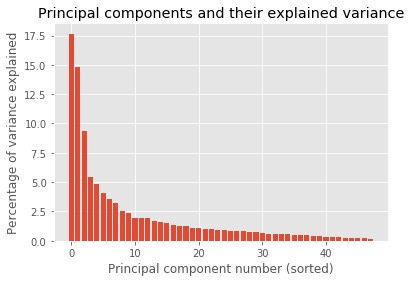

In [8]:
# how much of the variance is explained?
features = range(svd_test.n_components)
variance = sorted(svd_test.explained_variance_ratio_*100, reverse=True)
plt.bar(features, variance)
plt.xlabel("Principal component number (sorted)")
plt.ylabel("Percentage of variance explained")
plt.title("Principal components and their explained variance")

It is visually evident that many features have very small contribution to the variance explained. Therefore, I am keeping features that explain more tha 0.5% of the variance. The rest will be considered noise.

In [9]:
n_features = len([var for var in variance if var>0.5]) #features that explain at least 1% of variance

In [10]:
variance_explained = svd_test.explained_variance_ratio_[:n_features].sum()
print("{}% of the variance explained using 40 principal components.".format(round(100*variance_explained)))

97.0% of the variance explained using 40 principal components.


97% seems to be a reasonable value as it decreases the possibility of memorizing the data into principal components and avoiding the noise to crawl into the decision.  We are willing to sacrifice 3% of variance.

# Cluster sweet spot 

Now let's transform the data and check how many cluster is meaningful for our data?

In [11]:
svd40 = TruncatedSVD(n_components=n_features) # keeping more informative featuers
principals = svd40.fit_transform(csr_mat)

Now I want to know how the inertia (inter-clusster variabce) changes as I increase the number of clusters. We know that more clusters mean less variance, however, we want to see where is that sweet-spot knee-point from which we dont see that much improvement. I other words, we need to find the point that after which the slope of the curve is smaller than slope of the curve before it.

In [12]:
inertias = [] 
for i in range(1,15): # you can theoritically have 60 cluster (same as the number of poets)
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(principals)
    inertias.append(kmeans.inertia_)

Text(0.5,1,'Inertia vs number of clusters')

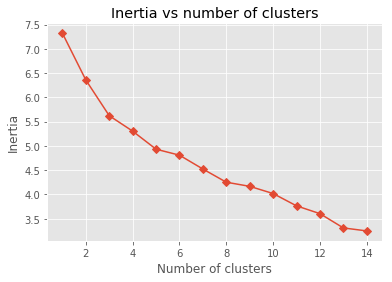

In [13]:
# visualizing the inertias
plt.plot(range(1,15), inertias, marker='D')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Inertia vs number of clusters")

We notice that three cluster looks as a good knee point. It is not perfect. However, the change of slope before and after it is evident.

# Developing the pipeline
Let's now develop the pipeline and run the clustering algorithm over the number of principal components and clusters we calculated above.

In [14]:
#developing a pipeline
svd= TruncatedSVD(n_components=n_features)
kmeans = KMeans(n_clusters=3)
pipeline = make_pipeline(svd, kmeans)

In [15]:
pipeline.fit(csr_mat)
labels = pipeline.predict(csr_mat) #Generating the labels for each class

Next, we will add the names into dataframe format.

In [16]:
df = pd.DataFrame({'labels': labels, 'poets': poet_labels_persian})
df = df.sort_values(by='labels')

In [17]:
for i in range(kmeans.n_clusters):
    grouped = df.loc[df['labels']==i,'poets'].values
    print("Poets grouped in category {} are:\n".format(i))
    print(grouped)

Poets grouped in category 0 are:

['ظهیر' 'سنایی' 'رودکی' 'منوچهری' 'قاآنی' 'فردوسی' 'فرخی' 'ناصر خسرو'
 'اسدی توسی' 'اسعد گرگانی' 'انوری' 'امیر معظی' 'عنصری']
Poets grouped in category 1 are:

['عبید زاکانی' 'نزاری قهستانی' 'وحشی بافقی' 'عرفی' 'اوحدی' 'سعدی'
 'امیرخسرو' 'خیام' 'خاقانی' 'هاتف اصفهانی' 'جامی' 'سلمان' 'حافظ' 'شبستری'
 'شاه نعمت الله' 'بیدل دهلوی' 'ملک الشعرای بهار' 'شیخ بهایی' 'بابافاضل'
 'شهریار' 'صائب' 'رهی معیری']
Poets grouped in category 2 are:

['سیف فرغانی' 'ابوسعید ابوالخیر' 'پروین اعتصامی' 'مولوی' 'کمال اسماعیل'
 'اقبال لاهوری' 'هلالی' 'گیلانی' 'فیض کاشانی' 'عراقی' 'عطار نیشابوری'
 'آرتیمانی' 'خاجوی کرمانی']


# Giving the poets actual labels

Having some background in Persian Literatures, I notice the pattern being used to cluster these poets. The first group of poets are "The Mystics", they talk about spirituality, ethics, and meaning. The second group, are the "The Wise", they are poets who have lived in Khorasan mostly in 16th century and their main theme was to talk about "Wisdom" through stories. There are a couple of outliers, such as "[Maleko Shoara](https://en.wikipedia.org/wiki/Mohammad-Taqi_Bahar)" who was a contemporary poet. However, you can say that he followed the same language and themes as the poets from Khorasan. And last group are the "Mainstream" poets. Their main team is to talk about love, lover, and God with large amount of methaphors.  
Please note that considering the large size of documents and small number of poets, the clusters are not ideal. There are cases that dont match the description. For example, [Parvin](https://en.wikipedia.org/wiki/Parvin_E%27tesami) can both be considered as Wise or Mystic, but obviously her poets are more tilted toward mystism.

In [18]:
label_map = {0:"Mystics",1:"Wise",2:"Mainstream"}

In [19]:
df['labels'] = df['labels'].apply(lambda x: label_map[x])

In [20]:
df.head()

,labels,poets
47,Mystics,ظهیر
41,Mystics,سنایی
37,Mystics,رودکی
26,Mystics,منوچهری
14,Mystics,قاآنی
